<a href="https://colab.research.google.com/github/JaimeWilson/Redes_Neurais_Data_science/blob/main/Series_Temporaisipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jaime Andrés Castañeda Barbosa
## Previsão de séries temporais

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline


In [2]:
def transform_data(data, lag = 1, test_split = 0.1, normalize = False, category = 'binary'):
    
    global _min
    global _max
    
    
    data_values = data.values
    
    if 0 < test_split < 1.0:
        l = data_values.shape[0]
        train_values = data_values[:-int(test_split*l),0].reshape(-1,1)
        test_values = data_values[-int(test_split*l):,0].reshape(-1,1)
        train_idx = data_values[:-int(test_split*l),1].reshape(-1,1)
        test_idx = data_values[-int(test_split*l):,1].reshape(-1,1)
        
    elif test_split > 1 and type(test_split) is int:

        train_values = data_values[:-test_split,0].reshape(-1,1)
        test_values = data_values[-test_split:,0].reshape(-1,1)
        train_idx = data_values[:-test_split,1].reshape(-1,1)
        test_idx = data_values[-test_split:,1].reshape(-1,1)
        
    else:
        print('Test split not understood. Test split should be float between 0 and 1 or integer for index')
    
    assert test_values.shape[0] >= (lag)
    
    _min = np.min(train_values)
    _max = np.max(train_values)
    
    if normalize:
        
        test_values = (test_values - _min)/(_max - _min)
        train_values = (train_values - _min)/(_max - _min)
        
    train_data = np.zeros((train_values.shape[0] - (lag + 1), lag + 2))
    test_data = np.zeros((test_values.shape[0], lag + 2))
    
    
    all_data = np.vstack((train_values,test_values))
    all_idx = np.vstack((train_idx,test_idx))

    new_data = np.zeros((train_values.shape[0] - (lag + 1) + test_values.shape[0],lag + 2))
    
    
    
    for i in range(lag + 2):
        new_data[:,i] = all_data[i:new_data.shape[0]+i,0]
        

    
    if category == 'binary':
        binary_rep = [np.binary_repr(z,width=4) for z in all_idx.astype('int').reshape(-1,)]
        t0 = np.array([int(v) for s in binary_rep for v in s[0]])
        t1 = np.array([int(v) for s in binary_rep for v in s[1]])
        t2 = np.array([int(v) for s in binary_rep for v in s[2]])
        t3 = np.array([int(v) for s in binary_rep for v in s[3]])
        t = np.vstack((t0,t1,t2,t3)).T
        t = t[-new_data.shape[0]:,:]
        temp_idx = [f'month_{i}' for i in range(4)]
        
    elif category == '1toN':
        t = (all_idx - np.min(train_idx))/(np.max(train_idx) - np.min(train_idx))
        t = t.reshape(-1,1)
        t = t[-new_data.shape[0]:,:]
        temp_idx = ['month']
    
    else:
        pass
    
    
    new_data = np.hstack((t,new_data))
    
    train_data = new_data[:-test_values.shape[0],:]
    test_data = new_data[-test_values.shape[0]:,:]
    
    
    data_columns = [f'y(t{i})' if i < 0 else 'y(t)' if i == 0 else f'y(t+{i})' for i in range(-lag,2)] 
    temp_idx.extend(data_columns)
    new_train_df = pd.DataFrame(train_data, columns=temp_idx)
    new_test_df = pd.DataFrame(test_data, columns=temp_idx)
    
    
    
    
    return new_train_df, new_test_df
        
    
    
    

In [3]:
raw_data = pd.read_csv('darwin.data',header=None)

In [4]:
raw_data['index'] = raw_data.index % 12

In [5]:
raw_data.head

<bound method NDFrame.head of          0  index
0      6.4      0
1      6.3      1
2      7.5      2
3      8.5      3
4      9.4      4
...    ...    ...
1395  11.1      3
1396  11.5      4
1397  12.1      5
1398  12.6      6
1399  12.7      7

[1400 rows x 2 columns]>

In [ ]:
#raw_data['mes_teste'] = raw_data.index % 2

In [ ]:
#raw_data.head(12) # 12 é a janela de tempo analisado

In [ ]:
#raw_data['mes_teste1'] = raw_data.index % 10

In [ ]:
#raw_data.head(12)

In [6]:
train,test = transform_data(raw_data,lag=12,test_split = 12,normalize=True,category='1toN')

In [7]:
train #aqui temos os valores anteriores e y(t+1) é o que queremos prever. Esses dados serão usados na entrada da rede

,month,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.090909,0.266129,0.258065,0.354839,0.435484,0.508065,0.741935,0.806452,0.814516,0.701613,0.508065,0.516129,0.217742,0.338710,0.282258
1,0.181818,0.258065,0.354839,0.435484,0.508065,0.741935,0.806452,0.814516,0.701613,0.508065,0.516129,0.217742,0.338710,0.282258,0.491935
2,0.272727,0.354839,0.435484,0.508065,0.741935,0.806452,0.814516,0.701613,0.508065,0.516129,0.217742,0.338710,0.282258,0.491935,0.427419
3,0.363636,0.435484,0.508065,0.741935,0.806452,0.814516,0.701613,0.508065,0.516129,0.217742,0.338710,0.282258,0.491935,0.427419,0.596774
4,0.454545,0.508065,0.741935,0.806452,0.814516,0.701613,0.508065,0.516129,0.217742,0.338710,0.282258,0.491935,0.427419,0.596774,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1370,0.272727,0.346774,0.475806,0.733871,0.750000,0.758065,0.750000,0.580645,0.532258,0.427419,0.201613,0.338710,0.137097,0.443548,0.709677
1371,0.363636,0.475806,0.733871,0.750000,0.758065,0.750000,0.580645,0.532258,0.427419,0.201613,0.338710,0.137097,0.443548,0.709677,0.709677
1372,0.454545,0.733871,0.750000,0.758065,0.750000,0.580645,0.532258,0.427419,0.201613,0.338710,0.137097,0.443548,0.709677,0.709677,0.935484
1373,0.545455,0.750000,0.758065,0.750000,0.580645,0.532258,0.427419,0.201613,0.338710,0.137097,0.443548,0.709677,0.709677,0.935484,0.903226


In [8]:
test

,month,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.727273,0.750000,0.580645,0.532258,0.427419,0.201613,0.338710,0.137097,0.443548,0.709677,0.709677,0.935484,0.903226,0.967742,0.935484
1,0.818182,0.580645,0.532258,0.427419,0.201613,0.338710,0.137097,0.443548,0.709677,0.709677,0.935484,0.903226,0.967742,0.935484,0.830645
2,0.909091,0.532258,0.427419,0.201613,0.338710,0.137097,0.443548,0.709677,0.709677,0.935484,0.903226,0.967742,0.935484,0.830645,0.669355
3,1.000000,0.427419,0.201613,0.338710,0.137097,0.443548,0.709677,0.709677,0.935484,0.903226,0.967742,0.935484,0.830645,0.669355,0.443548
4,0.000000,0.201613,0.338710,0.137097,0.443548,0.709677,0.709677,0.935484,0.903226,0.967742,0.935484,0.830645,0.669355,0.443548,0.379032
5,0.090909,0.338710,0.137097,0.443548,0.709677,0.709677,0.935484,0.903226,0.967742,0.935484,0.830645,0.669355,0.443548,0.379032,0.572581
6,0.181818,0.137097,0.443548,0.709677,0.709677,0.935484,0.903226,0.967742,0.935484,0.830645,0.669355,0.443548,0.379032,0.572581,0.556452
7,0.272727,0.443548,0.709677,0.709677,0.935484,0.903226,0.967742,0.935484,0.830645,0.669355,0.443548,0.379032,0.572581,0.556452,0.645161
8,0.363636,0.709677,0.709677,0.935484,0.903226,0.967742,0.935484,0.830645,0.669355,0.443548,0.379032,0.572581,0.556452,0.645161,0.677419
9,0.454545,0.709677,0.935484,0.903226,0.967742,0.935484,0.830645,0.669355,0.443548,0.379032,0.572581,0.556452,0.645161,0.677419,0.725806


In [9]:
train_values = train.values

x_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test.values
x_test = test_values[:,:-1]
y_test = test_values[:,-1]

In [10]:
def create_model(hidden_neurons = [4], hidden_activation = ['relu'], output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    model = Sequential()
    model.add(Dense(hidden_neurons[0], input_dim=n_input, activation='tanh'))
    for i in range(1,len(hidden_neurons)):
        model.add(Dense(hidden_neurons[i], input_dim=hidden_neurons[i-1], activation='tanh'))
        

    model.add(Dense(n_output, activation=output_activation))
    # Compile model
    opt = Adam(lr=lr)
    model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_absolute_error','mean_squared_error'])
    return model

In [11]:
model = create_model(hidden_neurons = [10], output_activation='linear', n_input = x_train.shape[1], n_output = 1, lr = 0.08)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
model.fit(x=x_train,y=y_train,epochs=50)

Epoch 1/50
43/43 [==============================] - 1s 1ms/step - loss: 0.1410 - mean_absolute_error: 0.1410 - mean_squared_error: 0.0678
Epoch 2/50
43/43 [==============================] - 0s 1ms/step - loss: 0.0868 - mean_absolute_error: 0.0868 - mean_squared_error: 0.0117
Epoch 3/50
43/43 [==============================] - 0s 1ms/step - loss: 0.0768 - mean_absolute_error: 0.0768 - mean_squared_error: 0.0094
Epoch 4/50
43/43 [==============================] - 0s 1ms/step - loss: 0.0732 - mean_absolute_error: 0.0732 - mean_squared_error: 0.0086
Epoch 5/50
43/43 [==============================] - 0s 1ms/step - loss: 0.0734 - mean_absolute_error: 0.0734 - mean_squared_error: 0.0087
Epoch 6/50
43/43 [==============================] - 0s 1ms/step - loss: 0.0950 - mean_absolute_error: 0.0950 - mean_squared_error: 0.0145
Epoch 7/50
43/43 [==============================] - 0s 2ms/step - loss: 0.0831 - mean_absolute_error: 0.0831 - mean_squared_error: 0.0107
Epoch 8/50
43/43 [================

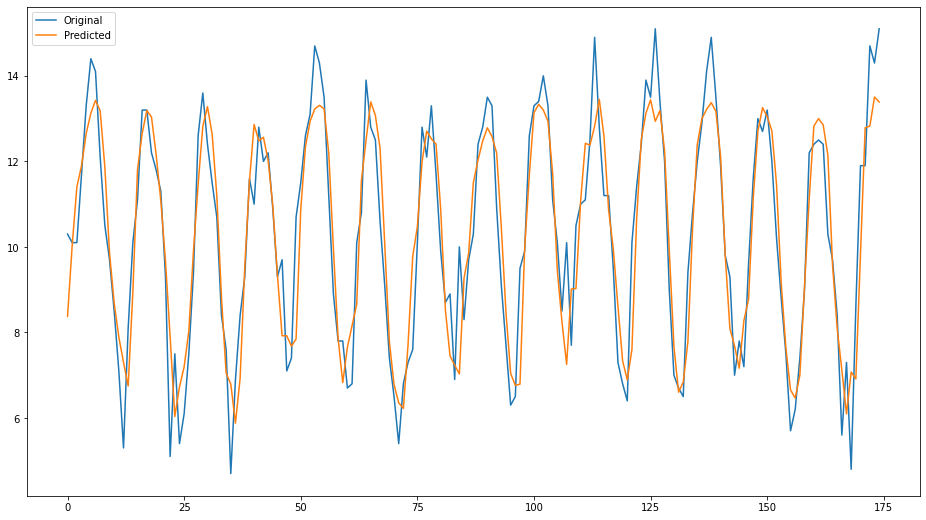

In [13]:
y_hat = model.predict(x_train)
plt.figure(figsize=(16,9))
plt.plot(y_train[1200:]*(_max-_min) + _min)
plt.plot(y_hat[1200:]*(_max-_min) + _min)
plt.legend(['Original','Predicted'])
# no gráfico o que esta em azul é o valor real e em laranja é a previsão

### Teste 'One step-ahead'

In [14]:
y_hat = model.predict(x_test) # esse valor já está normalizado

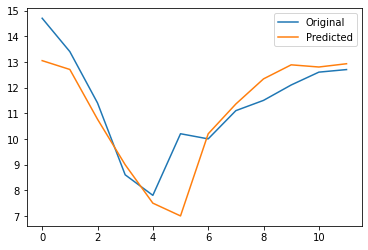

In [15]:
plt.plot(y_test*(_max-_min) + _min)
plt.plot(y_hat*(_max-_min) + _min)
plt.legend(['Original','Predicted'])

In [16]:
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_hat*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)
#acima ocorre a desnormalização para avaliar de fato o one-step.
print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

Erro MSE = 1.302 
Erro MAE = 0.782


### Teste Multi-step 

In [17]:
train,test = transform_data(raw_data,lag=12,test_split = 12,normalize=True,category='binary')

In [18]:
train

,month_0,month_1,month_2,month_3,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.0,0.0,0.0,1.0,0.266129,0.258065,0.354839,0.435484,0.508065,0.741935,0.806452,0.814516,0.701613,0.508065,0.516129,0.217742,0.338710,0.282258
1,0.0,0.0,1.0,0.0,0.258065,0.354839,0.435484,0.508065,0.741935,0.806452,0.814516,0.701613,0.508065,0.516129,0.217742,0.338710,0.282258,0.491935
2,0.0,0.0,1.0,1.0,0.354839,0.435484,0.508065,0.741935,0.806452,0.814516,0.701613,0.508065,0.516129,0.217742,0.338710,0.282258,0.491935,0.427419
3,0.0,1.0,0.0,0.0,0.435484,0.508065,0.741935,0.806452,0.814516,0.701613,0.508065,0.516129,0.217742,0.338710,0.282258,0.491935,0.427419,0.596774
4,0.0,1.0,0.0,1.0,0.508065,0.741935,0.806452,0.814516,0.701613,0.508065,0.516129,0.217742,0.338710,0.282258,0.491935,0.427419,0.596774,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1370,0.0,0.0,1.0,1.0,0.346774,0.475806,0.733871,0.750000,0.758065,0.750000,0.580645,0.532258,0.427419,0.201613,0.338710,0.137097,0.443548,0.709677
1371,0.0,1.0,0.0,0.0,0.475806,0.733871,0.750000,0.758065,0.750000,0.580645,0.532258,0.427419,0.201613,0.338710,0.137097,0.443548,0.709677,0.709677
1372,0.0,1.0,0.0,1.0,0.733871,0.750000,0.758065,0.750000,0.580645,0.532258,0.427419,0.201613,0.338710,0.137097,0.443548,0.709677,0.709677,0.935484
1373,0.0,1.0,1.0,0.0,0.750000,0.758065,0.750000,0.580645,0.532258,0.427419,0.201613,0.338710,0.137097,0.443548,0.709677,0.709677,0.935484,0.903226


In [19]:
test

,month_0,month_1,month_2,month_3,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,1.0,0.0,0.0,0.0,0.750000,0.580645,0.532258,0.427419,0.201613,0.338710,0.137097,0.443548,0.709677,0.709677,0.935484,0.903226,0.967742,0.935484
1,1.0,0.0,0.0,1.0,0.580645,0.532258,0.427419,0.201613,0.338710,0.137097,0.443548,0.709677,0.709677,0.935484,0.903226,0.967742,0.935484,0.830645
2,1.0,0.0,1.0,0.0,0.532258,0.427419,0.201613,0.338710,0.137097,0.443548,0.709677,0.709677,0.935484,0.903226,0.967742,0.935484,0.830645,0.669355
3,1.0,0.0,1.0,1.0,0.427419,0.201613,0.338710,0.137097,0.443548,0.709677,0.709677,0.935484,0.903226,0.967742,0.935484,0.830645,0.669355,0.443548
4,0.0,0.0,0.0,0.0,0.201613,0.338710,0.137097,0.443548,0.709677,0.709677,0.935484,0.903226,0.967742,0.935484,0.830645,0.669355,0.443548,0.379032
5,0.0,0.0,0.0,1.0,0.338710,0.137097,0.443548,0.709677,0.709677,0.935484,0.903226,0.967742,0.935484,0.830645,0.669355,0.443548,0.379032,0.572581
6,0.0,0.0,1.0,0.0,0.137097,0.443548,0.709677,0.709677,0.935484,0.903226,0.967742,0.935484,0.830645,0.669355,0.443548,0.379032,0.572581,0.556452
7,0.0,0.0,1.0,1.0,0.443548,0.709677,0.709677,0.935484,0.903226,0.967742,0.935484,0.830645,0.669355,0.443548,0.379032,0.572581,0.556452,0.645161
8,0.0,1.0,0.0,0.0,0.709677,0.709677,0.935484,0.903226,0.967742,0.935484,0.830645,0.669355,0.443548,0.379032,0.572581,0.556452,0.645161,0.677419
9,0.0,1.0,0.0,1.0,0.709677,0.935484,0.903226,0.967742,0.935484,0.830645,0.669355,0.443548,0.379032,0.572581,0.556452,0.645161,0.677419,0.725806


In [20]:
y_hat = model.predict(x_test)

In [21]:
step = x_test[0]
for i in range(12):
    y_hat
    step = step[:] + y_hat
    guardar = step

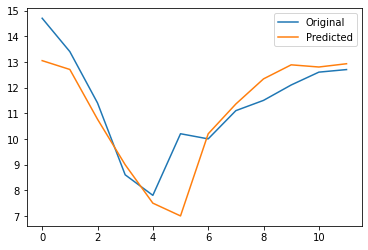

In [22]:
plt.plot(y_test*(_max-_min) + _min)
plt.plot(y_hat*(_max-_min) + _min)
plt.legend(['Original','Predicted'])


In [23]:
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_hat*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

Erro MSE = 1.302 
Erro MAE = 0.782


In [24]:
train,test = transform_data(raw_data,lag=12,test_split = 12,normalize=True,category='1toN')